<a href="https://colab.research.google.com/github/AdamKlasa/Chest_X-Ray_Dataset/blob/master/Chest_X_Ray_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


## Download dataset from repo, create dataloaders and visualize

In [4]:
! git clone https://github.com/AdamKlasa/Chest_X-Ray_Dataset.git

fatal: destination path 'Chest_X-Ray_Dataset' already exists and is not an empty directory.


In [0]:
train_set = torchvision.datasets.ImageFolder('./Chest_X-Ray_Dataset/train', transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]))
test_set = torchvision.datasets.ImageFolder('./Chest_X-Ray_Dataset/test', transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]))
val_set = torchvision.datasets.ImageFolder('./Chest_X-Ray_Dataset/val', transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]))

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True, num_workers=1)

In [0]:
images, labels = next(iter(val_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


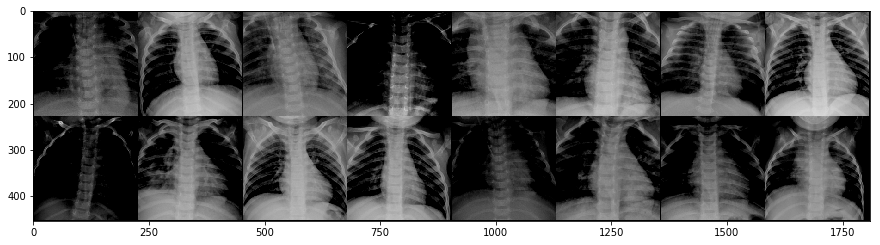

In [7]:
grid = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1,2,0)))

## My convolutional network models

In [0]:
class Network_with_2_layers(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4)

        self.fc1 = nn.Linear(in_features=128 * 53 * 53, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 128 * 53 * 53)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = self.out(t)

        return t


class Network_with_4_layers(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4)

        self.fc1 = nn.Linear(in_features=512 * 11 * 11, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 512 * 11 * 11)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = self.fc3(t)
        t = F.relu(t)

        t = self.fc4(t)
        t = F.relu(t)

        t = self.out(t)

        return t      

## Modifying VGG16 to have 2 outputs in the last layer

In [0]:
def VGG16_with_2_outputs():
    network = torchvision.models.vgg16(pretrained=True, progress=True)

    for param in network.parameters():
        param.require_grad = False

    num_features = network.classifier[6].in_features
    features = list(network.classifier.children())[:-1]

    features.extend([nn.Linear(num_features, len(train_set.classes))])
    network.classifier = nn.Sequential(*features)

    network.cuda()
    return network

## Get number of correct guesses helper function


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

## Plot ROC Curve function

In [0]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Evaluiting function

In [0]:
def eval_model(network, load_state_dict=False):
    network.cuda()
    network.train(False)
    network.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch            
            images, labels = images.cuda(), labels.cuda()   
            
            preds = network(images)
            correct += get_num_correct(preds, labels)
            
            total += labels.size(0)


    print(f'Correct predictions: {correct} out of {total} ({(100 * (correct / total)):.4f}%)')

    accuracy_score = sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu().argmax(dim=1))
    print(f'Accuracy score: {accuracy_score:.4f}')

    roc_auc_score = sklearn.metrics.roc_auc_score(labels.cpu(), preds.cpu().argmax(dim=1))
    print(f'ROC auc score: {roc_auc_score:.4f}')

    precision_score = sklearn.metrics.precision_score(labels.cpu(), preds.cpu().argmax(dim=1), labels=train_set.classes)
    print(f'Precision score: {precision_score:.4f}')

    fpr, tpr, theresholds = sklearn.metrics.roc_curve(labels.cpu(), preds.cpu().argmax(dim=1))

    plot_roc_curve(fpr, tpr)


## Training function

In [0]:
def train_model(network, num_epochs, learning_rate):
    network.cuda()
    network.train()

    # optimizer = optim.SGD(network.parameters(), lr=learning_rate)
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch
            images, labels = images.cuda(), labels.cuda()

            preds = network(images)
            loss = torch.nn.functional.cross_entropy(preds, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Total loss: {total_loss:.4f}')        
        print(f'Error rate: {1 - sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu().argmax(dim=1))}')
        print('-' * 10)

            
    print('Training complete...')   
    

## Training stats for 2 layer conv network and testing the performance (SGD optimizer)

Epoch 1/4
----------
Total loss: 47.3519
Error rate: 0.4375
----------
Epoch 2/4
----------
Total loss: 41.9181
Error rate: 0.3125
----------
Epoch 3/4
----------
Total loss: 37.9726
Error rate: 0.1875
----------
Epoch 4/4
----------
Total loss: 35.9552
Error rate: 0.125
----------
Training complete...
Correct predictions: 457 out of 624 (73.2372%)
Accuracy score: 0.6667
ROC auc score: 0.6000
Precision score: 0.6364


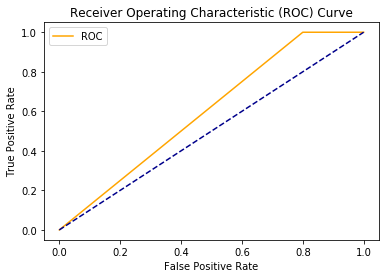

In [193]:
network_with_2_layers = Network_with_2_layers()
train_model(network_with_2_layers, num_epochs=4, learning_rate=0.01)
eval_model(network_with_2_layers)

^ Seems like error rate is funny, getting worse over time with big jumps.

Epoch 1/4
----------
Total loss: 50.7067
Error rate: 0.375
----------
Epoch 2/4
----------
Total loss: 47.9173
Error rate: 0.15625
----------
Epoch 3/4
----------
Total loss: 47.1116
Error rate: 0.28125
----------
Epoch 4/4
----------
Total loss: 46.6966
Error rate: 0.25
----------
Training complete...
Correct predictions: 390 out of 624 (62.5000%)
Accuracy score: 0.5833
ROC auc score: 0.5000
Precision score: 0.5833


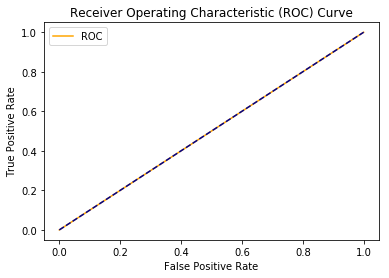

In [194]:
network_with_2_layers = Network_with_2_layers()
train_model(network_with_2_layers, num_epochs=4, learning_rate=0.001)
eval_model(network_with_2_layers)

^This looks better

Epoch 1/4
----------
Total loss: 56.4127
Error rate: 0.15625
----------
Epoch 2/4
----------
Total loss: 55.4277
Error rate: 0.25
----------
Epoch 3/4
----------
Total loss: 54.6160
Error rate: 0.34375
----------
Epoch 4/4
----------
Total loss: 53.8878
Error rate: 0.125
----------
Training complete...
Correct predictions: 390 out of 624 (62.5000%)
Accuracy score: 0.6875
ROC auc score: 0.5000
Precision score: 0.6875


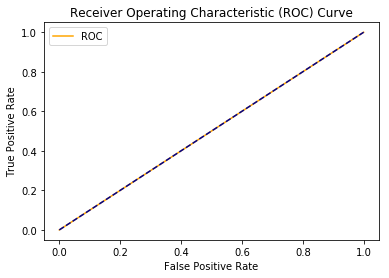

In [195]:
network_with_2_layers = Network_with_2_layers()
train_model(network_with_2_layers, num_epochs=4, learning_rate=0.0001)
eval_model(network_with_2_layers)

## The same for the 4 layer model (still SGD)

Epoch 1/4
----------
Total loss: 52.6808
Error rate: 0.1875
----------
Epoch 2/4
----------
Total loss: 48.5608
Error rate: 0.21875
----------
Epoch 3/4
----------
Total loss: 47.3571
Error rate: 0.3125
----------
Epoch 4/4
----------
Total loss: 46.9521
Error rate: 0.28125
----------
Training complete...
Correct predictions: 390 out of 624 (62.5000%)
Accuracy score: 0.6458
ROC auc score: 0.5000
Precision score: 0.6458


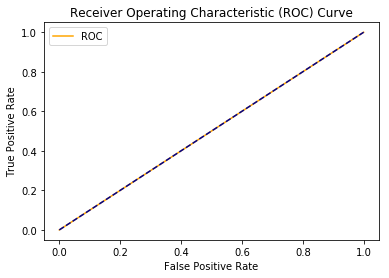

In [196]:
network_with_4_layers = Network_with_4_layers()
train_model(network_with_4_layers, num_epochs=4, learning_rate=0.01)
eval_model(network_with_4_layers)

Epoch 1/4
----------
Total loss: 59.3053
Error rate: 0.71875
----------
Epoch 2/4
----------
Total loss: 58.1573
Error rate: 0.875
----------
Epoch 3/4
----------
Total loss: 57.1088
Error rate: 0.09375
----------
Epoch 4/4
----------
Total loss: 56.1795
Error rate: 0.40625
----------
Training complete...
Correct predictions: 390 out of 624 (62.5000%)
Accuracy score: 0.6250
ROC auc score: 0.5000
Precision score: 0.6250


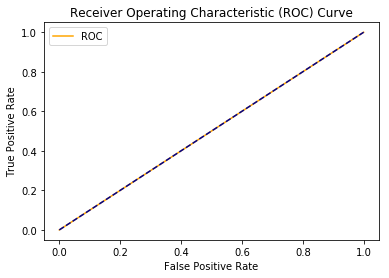

In [197]:
network_with_4_layers = Network_with_4_layers()
train_model(network_with_4_layers, num_epochs=4, learning_rate=0.001)
eval_model(network_with_4_layers)

Epoch 1/4
----------
Total loss: 54.2548
Error rate: 0.25
----------
Epoch 2/4
----------
Total loss: 54.1725
Error rate: 0.15625
----------
Epoch 3/4
----------
Total loss: 54.1098
Error rate: 0.3125
----------
Epoch 4/4
----------
Total loss: 54.0226
Error rate: 0.125
----------
Training complete...
Correct predictions: 390 out of 624 (62.5000%)
Accuracy score: 0.6458
ROC auc score: 0.5000
Precision score: 0.6458


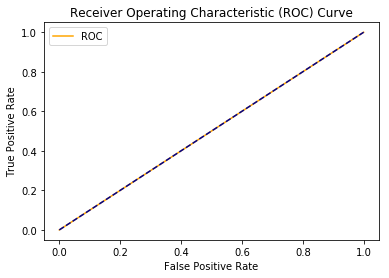

In [198]:
network_with_4_layers = Network_with_4_layers()
train_model(network_with_4_layers, num_epochs=4, learning_rate=0.0001)
eval_model(network_with_4_layers)

## Different optimizer => Adam

Epoch 1/4
----------
Total loss: 45.1772
Error rate: 0.28125
----------
Epoch 2/4
----------
Total loss: 33.4916
Error rate: 0.15625
----------
Epoch 3/4
----------
Total loss: 31.0840
Error rate: 0.09375
----------
Epoch 4/4
----------
Total loss: 26.7914
Error rate: 0.125
----------
Training complete...
Correct predictions: 521 out of 624 (83.4936%)
Accuracy score: 0.8542
ROC auc score: 0.7500
Precision score: 0.8293


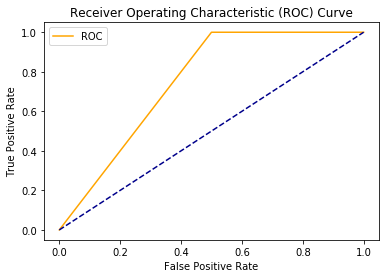

In [201]:
network_with_2_layers = Network_with_2_layers()
train_model(network_with_2_layers, num_epochs=4, learning_rate=0.001)
eval_model(network_with_2_layers)

Epoch 1/4
----------
Total loss: 45.3722
Error rate: 0.34375
----------
Epoch 2/4
----------
Total loss: 40.1658
Error rate: 0.34375
----------
Epoch 3/4
----------
Total loss: 30.8727
Error rate: 0.15625
----------
Epoch 4/4
----------
Total loss: 28.5157
Error rate: 0.15625
----------
Training complete...
Correct predictions: 489 out of 624 (78.3654%)
Accuracy score: 0.8125
ROC auc score: 0.7353
Precision score: 0.7750


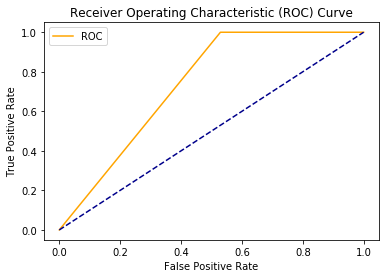

In [202]:
network_with_4_layers = Network_with_4_layers()
train_model(network_with_4_layers, num_epochs=4, learning_rate=0.001)
eval_model(network_with_4_layers)

## Time for VGG16 - optimized with Adam

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 96691057.01it/s]


Epoch 1/4
----------
Total loss: 101.3626
Error rate: 0.375
----------
Epoch 2/4
----------
Total loss: 47.0413
Error rate: 0.28125
----------
Epoch 3/4
----------
Total loss: 46.9078
Error rate: 0.28125
----------
Epoch 4/4
----------
Total loss: 46.8222
Error rate: 0.15625
----------
Training complete...
Correct predictions: 390 out of 624 (62.5000%)
Accuracy score: 0.7083
ROC auc score: 0.5000
Precision score: 0.7083


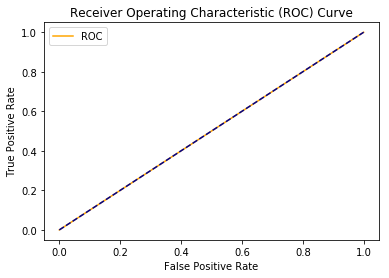

In [17]:
VGG16_with_2_outputs = VGG16_with_2_outputs()
train_model(VGG16_with_2_outputs, num_epochs=4, learning_rate=0.001)
eval_model(VGG16_with_2_outputs)

## VGG16 - optimized with SGD

Epoch 1/4
----------
Total loss: 37.4528
Error rate: 0.15625
----------
Epoch 2/4
----------
Total loss: 25.8779
Error rate: 0.1875
----------
Epoch 3/4
----------
Total loss: 22.7944
Error rate: 0.0625
----------
Epoch 4/4
----------
Total loss: 21.4910
Error rate: 0.09375
----------
Training complete...
Correct predictions: 520 out of 624 (83.3333%)
Accuracy score: 0.8750
ROC auc score: 0.8594
Precision score: 0.9062


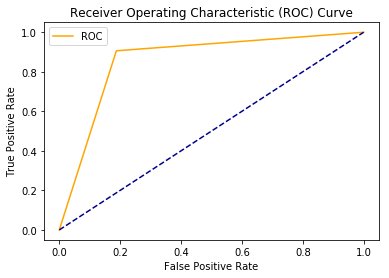

In [15]:
VGG16_with_2_outputs = VGG16_with_2_outputs()
train_model(VGG16_with_2_outputs, num_epochs=4, learning_rate=0.001)
eval_model(VGG16_with_2_outputs)

## Perhaps more training will get my best network closer?

Epoch 1/10
----------
Total loss: 48.1731
Error rate: 0.25
----------
Epoch 2/10
----------
Total loss: 39.5641
Error rate: 0.03125
----------
Epoch 3/10
----------
Total loss: 34.8705
Error rate: 0.0625
----------
Epoch 4/10
----------
Total loss: 33.4580
Error rate: 0.125
----------
Epoch 5/10
----------
Total loss: 32.5594
Error rate: 0.28125
----------
Epoch 6/10
----------
Total loss: 29.6121
Error rate: 0.0625
----------
Epoch 7/10
----------
Total loss: 27.6763
Error rate: 0.0
----------
Epoch 8/10
----------
Total loss: 27.2189
Error rate: 0.09375
----------
Epoch 9/10
----------
Total loss: 25.8868
Error rate: 0.09375
----------
Epoch 10/10
----------
Total loss: 24.8503
Error rate: 0.125
----------
Training complete...
Correct predictions: 499 out of 624 (79.9679%)
Accuracy score: 0.7708
ROC auc score: 0.6875
Precision score: 0.7692


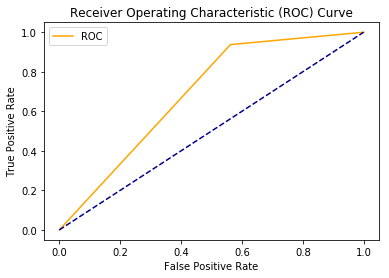

In [17]:
# Optimizer - Adam

network_with_4_layers = Network_with_4_layers()
train_model(network_with_4_layers, num_epochs=10, learning_rate=0.001)
eval_model(network_with_4_layers)

Wow! That's close.